In [1]:
import jupyter
import matplotlib.pyplot as plt
import numpy as np
from numpy import interp
import pandas as pd
from itertools import cycle
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, auc, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import math
from data import Data


In [2]:
def load_data(file):
    data = []
    with open(file) as f:
        for line in f:
            data.append(line.strip("\n").split(","))
    return data

def decision_tree(data, classLabel):
    arbre = tree.DecisionTreeClassifier(random_state=42)
    return arbre.fit(data, classLabel)




In [3]:
# Chargement des données
data = Data(load_data("glass.data"))

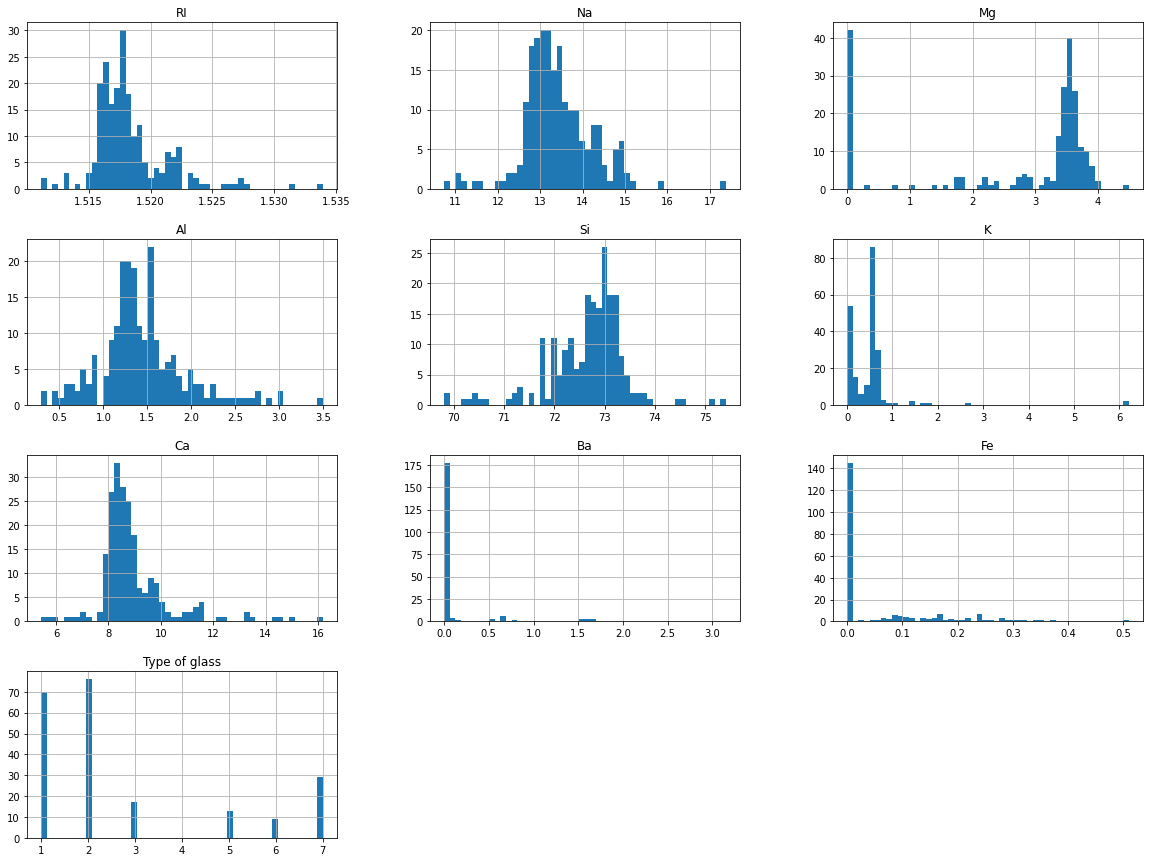

In [4]:
# D1.Histogramme pour toutes les classes 

data.data_frame.hist(bins=50, figsize=(20, 15))
plt.show()

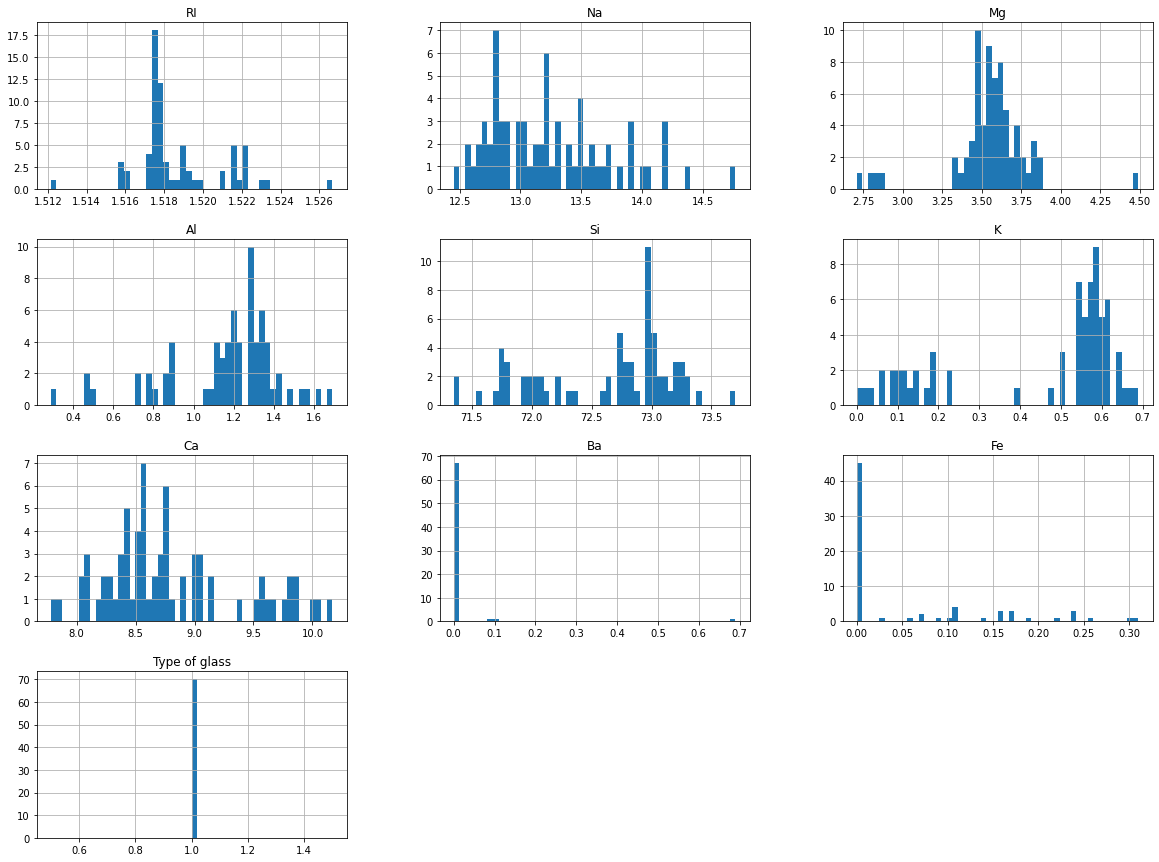

In [5]:
# D2.Histogramme pour la classe 1

data.getClassData(1).hist(bins=50, figsize=(20, 15))
plt.show()

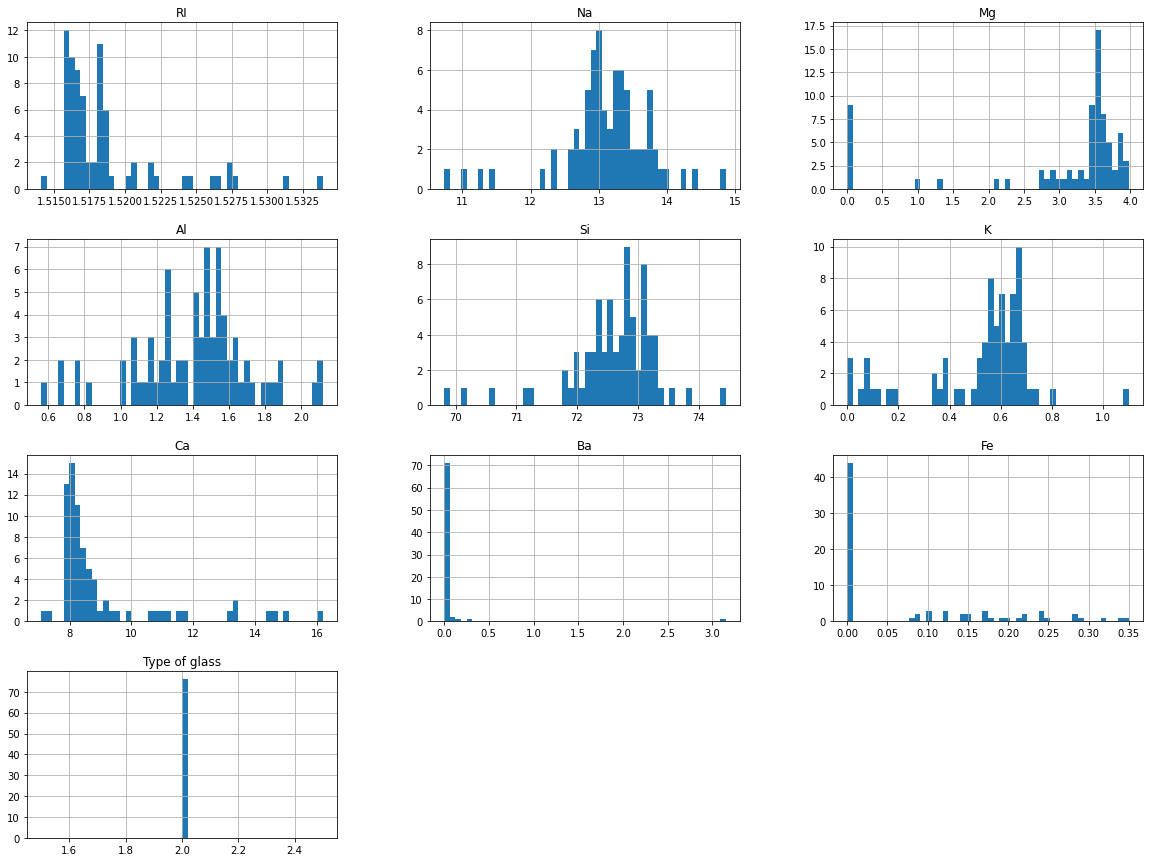

In [6]:
# D3.Histogramme pour la classe 2

data.getClassData(2).hist(bins=50, figsize=(20, 15))
plt.show()

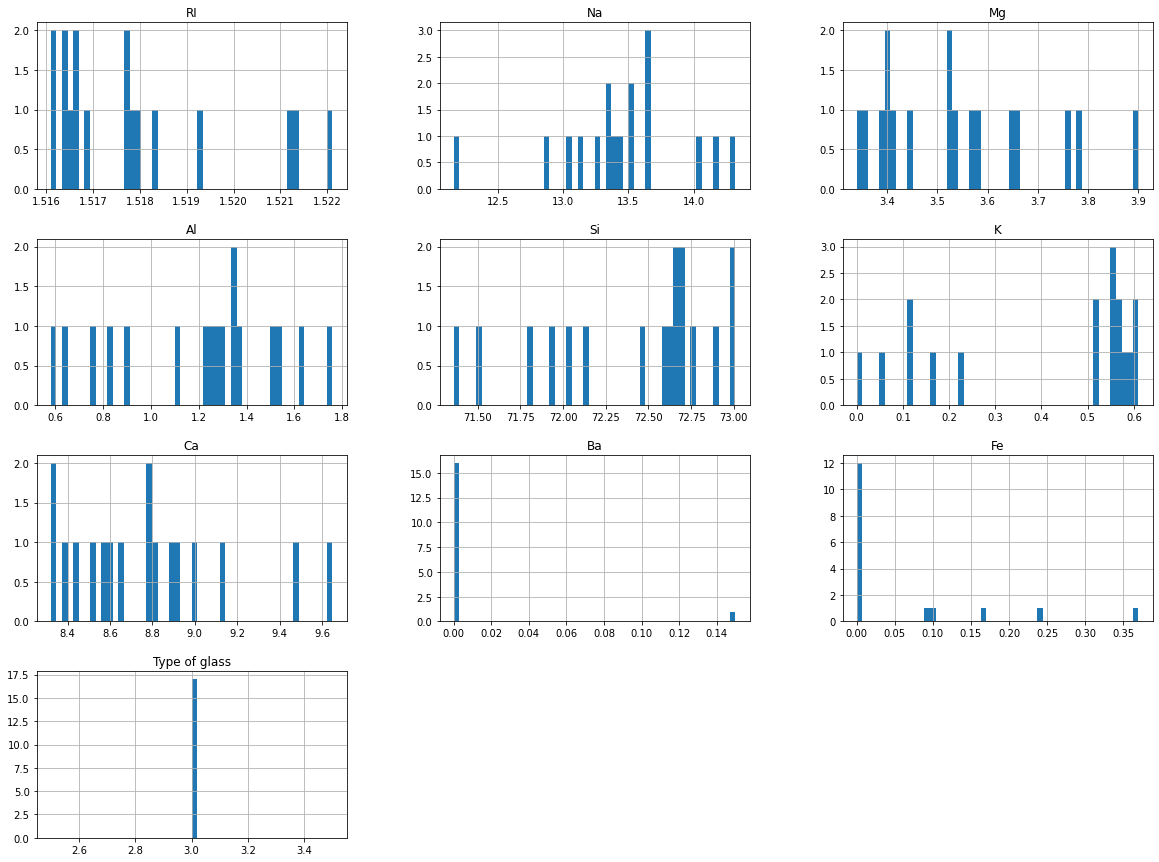

In [7]:
# D4.Histogramme pour la classe 3

data.getClassData(3).hist(bins=50, figsize=(20, 15))
plt.show()

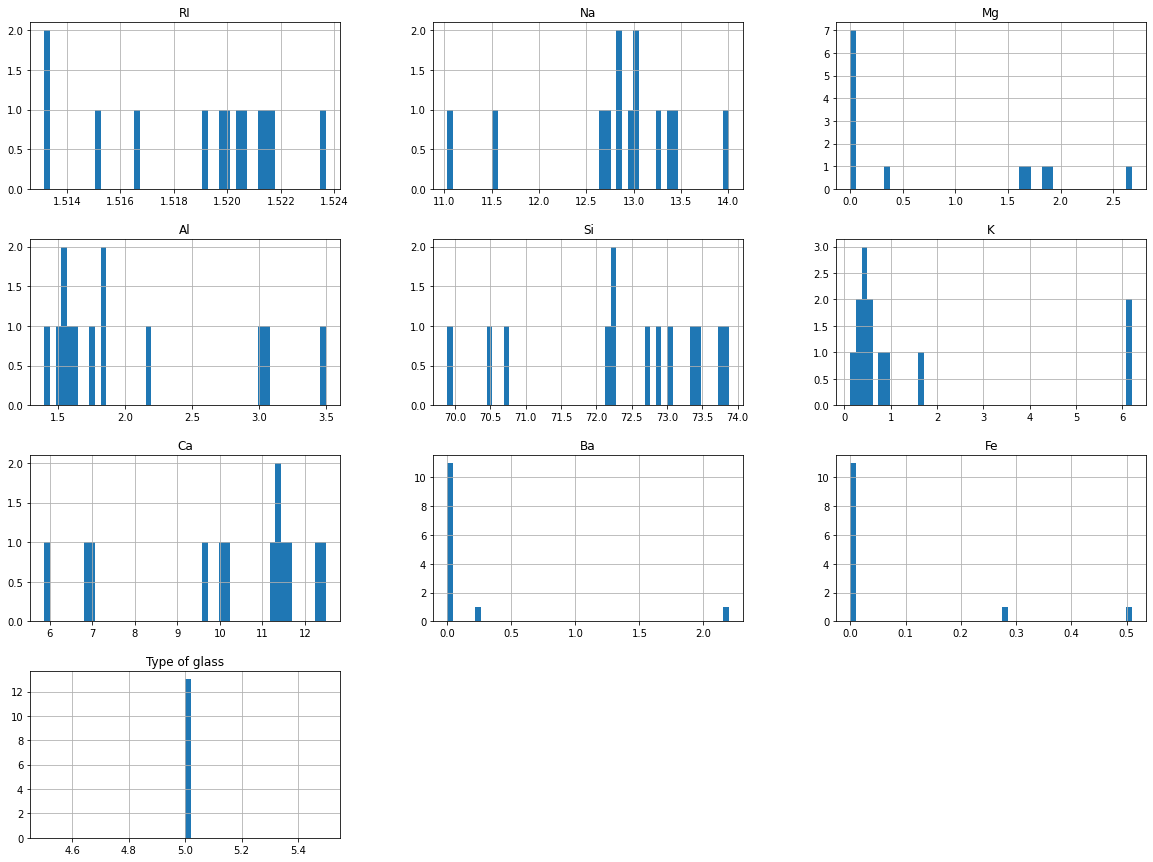

In [8]:
# D5.Histogramme pour la classe 5

data.getClassData(5).hist(bins=50, figsize=(20, 15))
plt.show()

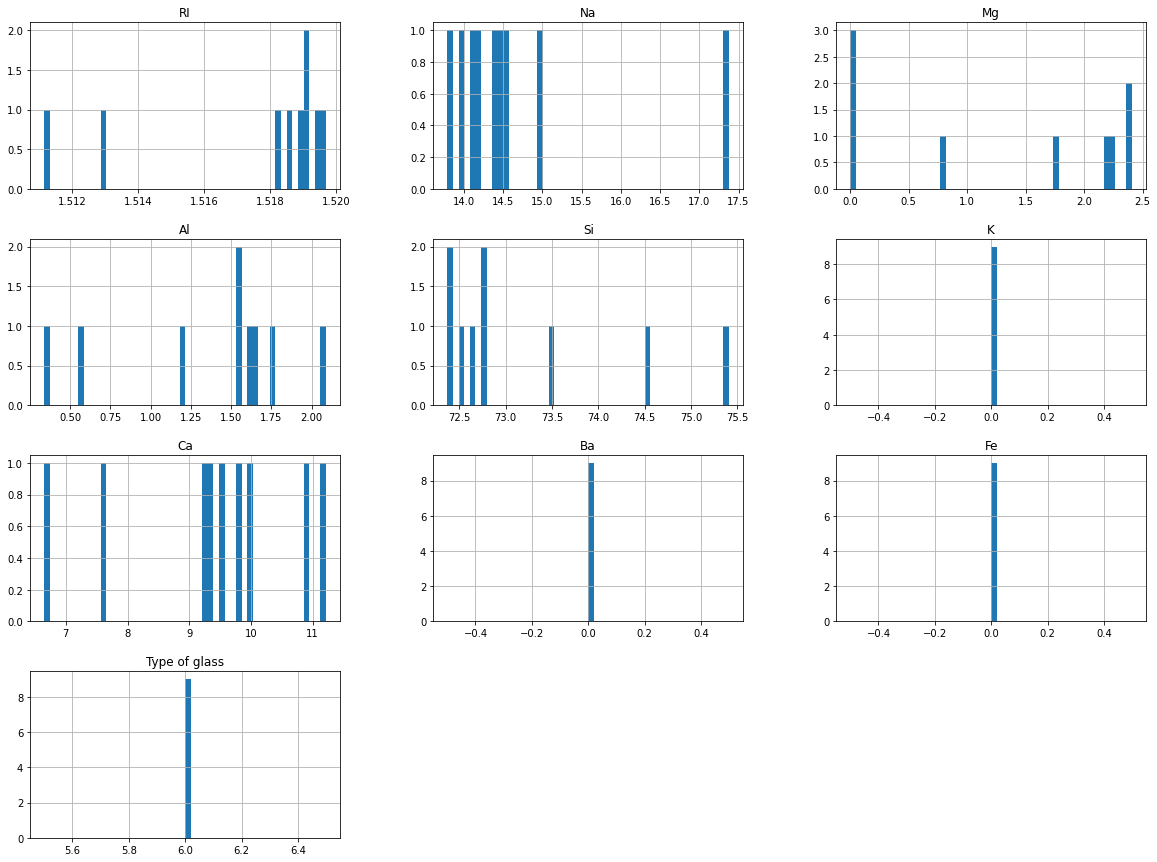

In [9]:
# D6.Histogramme pour la classe 6

data.getClassData(6).hist(bins=50, figsize=(20, 15))
plt.show()

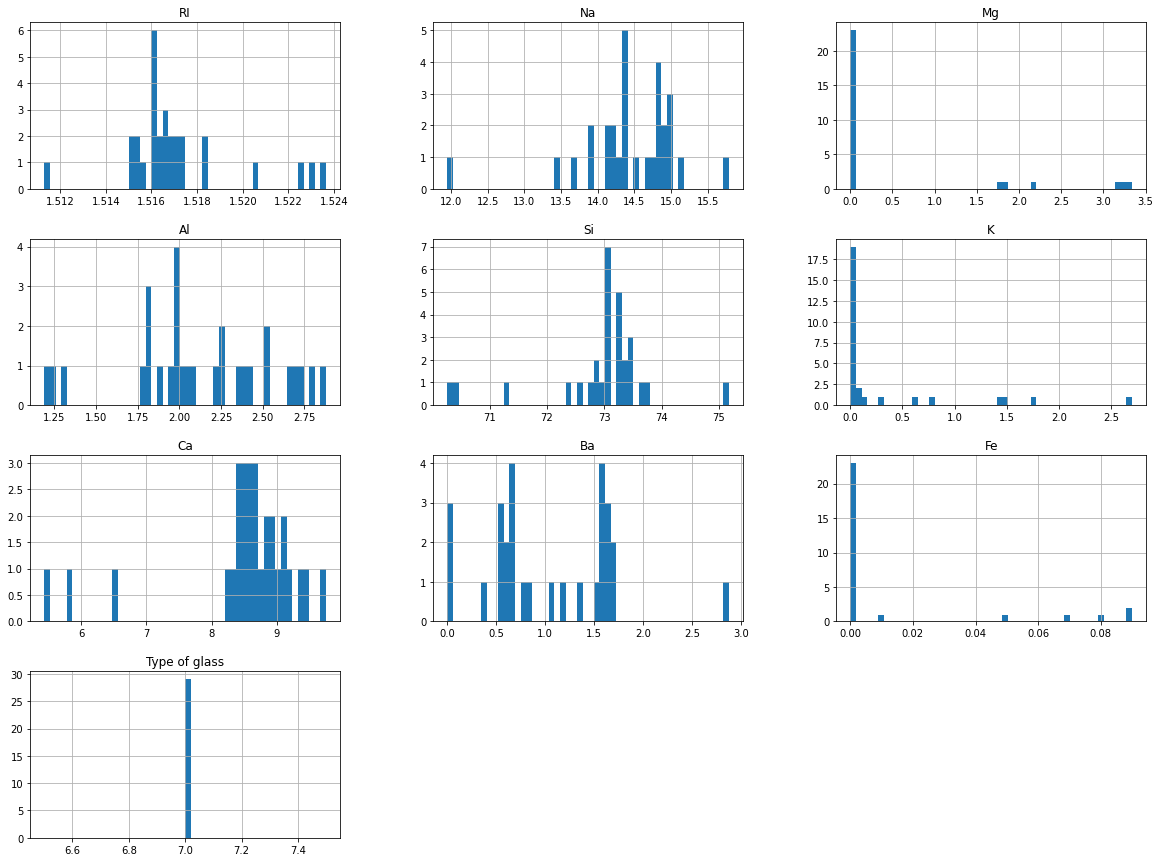

In [10]:
# D7.Histogramme pour la classe 7

data.getClassData(7).hist(bins=50, figsize=(20, 15))
plt.show()

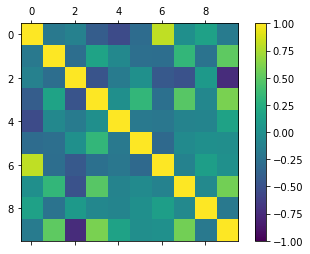

In [11]:
# D8.Matrice de confusion pour toutes les classes

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data.data_frame.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

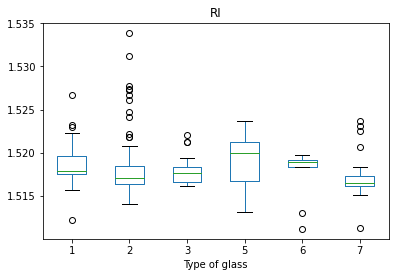

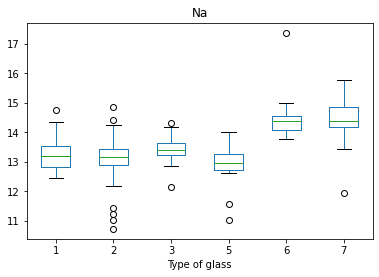

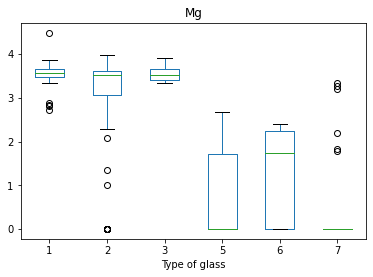

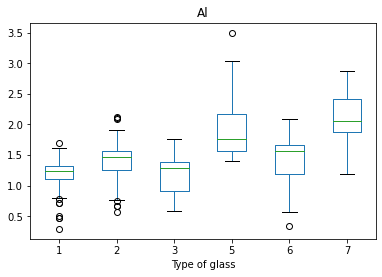

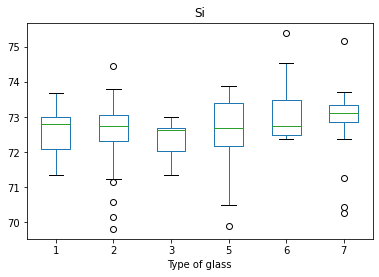

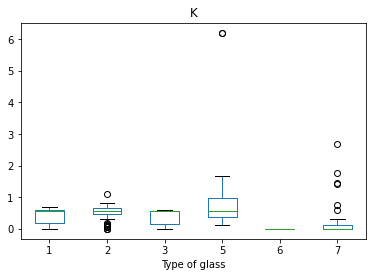

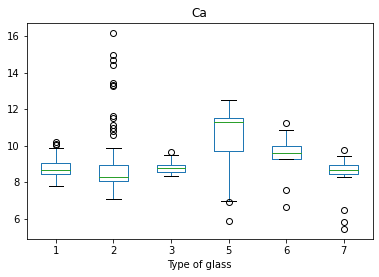

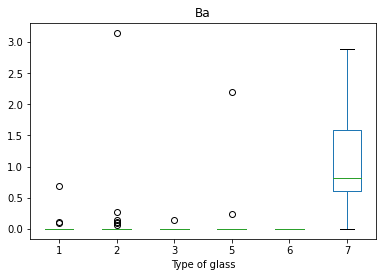

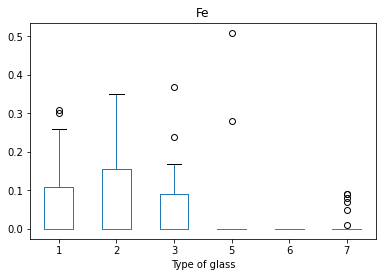

In [12]:
# D9.Diagrammes à moustache pour chaque attribut selon la classe

for column in data.data_frame.columns:
    if column == "Type of glass":
        continue
    data.data_frame.boxplot(column=column, by="Type of glass", grid=False)
    plt.suptitle('')
    plt.show()
    
    del(column)

In [13]:
# Suppresion d'attributs
data.removeColumn("Fe") # attribut inutile puisque les données sont les même(à peu près) pour toutes les classes si on se fie aux histogrammes

# Suppression des données abhérantes c-a-d les outliers
data.removeOutliers()

In [14]:
# Discretisation des attributs

# la stratégie est grosso-modo la suivante : Si l'histogramme de l'attribut à discrétiser
# montre une répartition normale, cet attribut est discrétisé selon un nombre variable(dépendant
# de la répartition de la gaussienne) de quantiles. Si l'histogramme montre des démarcations
# claires, les points d'arrêts sont choisis manuellement.

data.discretizeAuto("RI", 5)
data.discretizeAuto("Na", 6)
data.discretizeManual("Mg", [0, 1, 3, 3.4, 3.7, 6])
data.discretizeAuto("Al", 6)
data.discretizeAuto("Si", 5)
data.discretizeManual("K", [0, 0.2, 0.7, 7])
data.discretizeAuto("Ca", 4)
data.discretizeManual("Ba", [0, 0.5, 1.5, 4])



In [15]:
# Séparation des données en ensembles d'entrainement et de test

train_features, test_features, train_label, test_label= data.splitData(0.2)

In [16]:
# Arbre de décision et prédiction

arbre = decision_tree(train_features, train_label)

arbre_prediction = arbre.predict(test_features)

print("Arbre de décision : %f " % accuracy_score(test_label, arbre_prediction))

Arbre de décision : 0.700000 


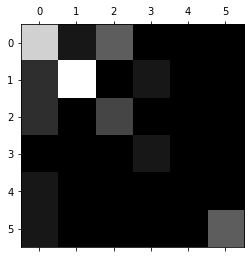

In [17]:
# Matrice de confusion pour l'arbre de décision

conf_mx = confusion_matrix(test_label, arbre_prediction)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [18]:
def elaguerArbre(arbre, nbr_noeuds_cible):
    """Élague un arbre donné jusqu'au nombre de noeud cible donné"""
    
    path = arbre.cost_complexity_pruning_path(train_features, train_label)
    arbre_ccp_alphas, arbre_impurities = path.ccp_alphas, path.impurities
    for i in range(len(arbre_ccp_alphas)):
        clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=arbre_ccp_alphas[i])
        clf.fit(train_features, train_label)
        if(clf.tree_.node_count <= nbr_noeuds_cible):
            return clf

    return clf

In [19]:
# Arbre de décision avec 10 noeuds et prédiction

arbre_elaguer = elaguerArbre(arbre,10)
arbre_elaguer_prediction = arbre_elaguer.predict(test_features)

print("Arbre de décision avec <= 10 noeuds : %f " % accuracy_score(test_label, arbre_elaguer_prediction))

Arbre de décision avec <= 10 noeuds : 0.650000 


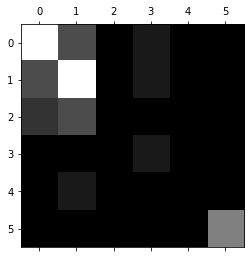

In [20]:
# Matrice de confusion de l'arbre élagué

conf_mx = confusion_matrix(test_label, arbre_elaguer_prediction)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [21]:
# Classificateur random forest et prédiction

forest = RandomForestClassifier()
forest.fit(train_features, train_label)
forest_prediction = forest.predict(test_features)
print("Random Forest : %f " % accuracy_score(test_label, forest_prediction))

Random Forest : 0.750000 


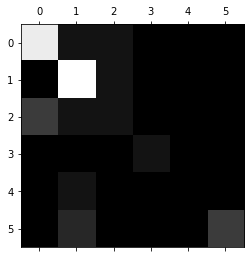

In [22]:
# Matrice de confusion pour le classificateur random forest

conf_mx_forest = confusion_matrix(test_label, forest_prediction)
plt.matshow(conf_mx_forest, cmap=plt.cm.gray)
plt.show()


In [23]:
# Test des différents attributs et leurs importances
for name, score in zip(data.data_frame[data.getFeatures()], forest.feature_importances_):
    print(name, score)

RI 0.16641117690393809
Na 0.13155431113550012
Mg 0.1753483064593638
Al 0.17603754511467962
Si 0.11590070113120608
K 0.059542773884521755
Ca 0.1149770211021672
Ba 0.060228164268623416


In [24]:
# Classificateur Bayes naif et prédiction

baye = GaussianNB().fit(train_features, train_label)
bayes_prediction = baye.predict(test_features)
print("Baye naif : %f " % accuracy_score(test_label, bayes_prediction))


Baye naif : 0.475000 


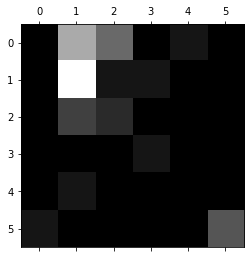

In [25]:
# Matrice de confusion pour le classificateur bayes naif

conf_mx_bayes = confusion_matrix(test_label, bayes_prediction)
plt.matshow(conf_mx_bayes, cmap=plt.cm.gray)
plt.show()

In [26]:
# Classificateur KNN guaussien et prédiction

neigh = KNeighborsClassifier(n_neighbors = round(math.sqrt(train_features.shape[0])/7))
neigh.fit(train_features, train_label)
knn_prediction = neigh.predict(test_features)

print("KNN : %f " % accuracy_score(test_label, knn_prediction))

KNN : 0.575000 


e:\Depot_Git\inf5081\inf5081-tp1\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


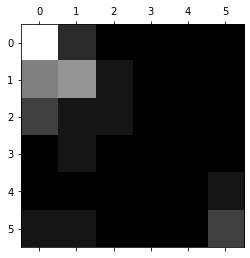

In [27]:
# Matrice de confusion pour le classificateur KNN guaussien

conf_mx_knn = confusion_matrix(test_label, knn_prediction)
plt.matshow(conf_mx_knn, cmap=plt.cm.gray)
plt.show()

In [28]:
def afficherRoc(classifier, n_classes, bin_X_train, bin_X_test, bin_y_train, bin_y_test, title):
    """Affiche le graphique ROC correspondant au classificateur donné et aux données binarisées"""

    classifierOvR = OneVsRestClassifier(classifier)
    y_score = classifierOvR.fit(bin_X_train, bin_y_train).predict(bin_X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(bin_y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(bin_y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    lw = 2
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i+1 if i < 4 else i + 2, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [29]:
# calcul de la courbe de ROC des 5 classificateurs et leurs diagrammes

n_classes= 6
X_train, X_test, y_train, y_test = data.splitBinarizedData(0.2)

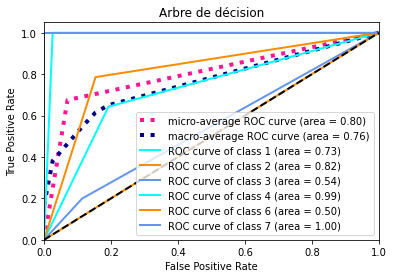

In [30]:
# Courbe ROC du classificateur arbre de décision

afficherRoc(arbre, n_classes, X_train, X_test, y_train, y_test,"Arbre de décision")

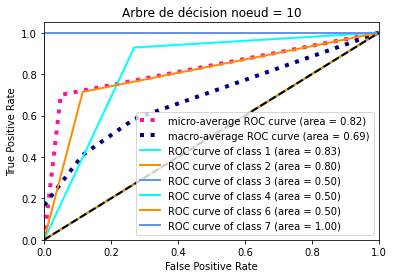

In [31]:
# Courbe ROC du classificateur arbre de décision élagué à 10 noeuds

afficherRoc(arbre_elaguer, n_classes, X_train, X_test, y_train, y_test,"Arbre de décision noeud = 10")

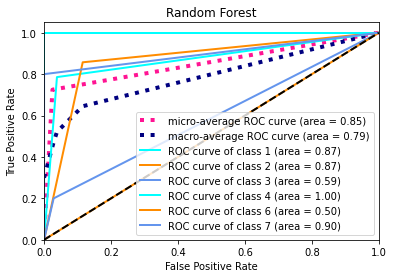

In [32]:
# Courbe ROC du classificateur random forest

afficherRoc(forest, n_classes, X_train, X_test, y_train, y_test,"Random Forest")

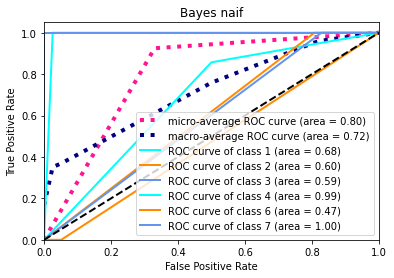

In [33]:
# Courbe ROC du classificateur bayes naif

afficherRoc(baye, n_classes, X_train, X_test, y_train, y_test,"Bayes naif")

e:\Depot_Git\inf5081\inf5081-tp1\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
e:\Depot_Git\inf5081\inf5081-tp1\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
e:\Depot_Git\inf5081\inf5081-tp1\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
e:\Depot_Git\inf5081\inf5081-tp1\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
e:\Depot_Git\inf5081\inf5081-tp1\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
e:\Depot_G

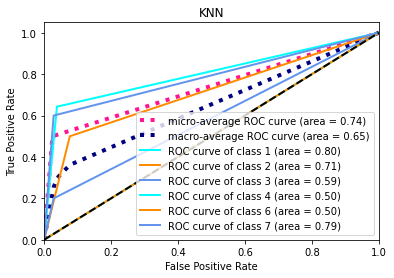

In [34]:
# Courbe ROC du classificateur KNN Guaussien

afficherRoc(neigh, n_classes, X_train, X_test, y_train, y_test,"KNN")

In [35]:
# '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# ------------------------------------- ANNEXE ------------------------------------------
# .......................................................................................

In [36]:

names_int = pd.unique(data.data_frame["Type of glass"])
target_names = []
for elem in names_int:
    target_names.append(str(elem))

In [37]:
# D11. Données à propos du classificateur d'arbre de décision

print(classification_report(test_label, arbre_prediction, target_names = target_names, zero_division=0))

              precision    recall  f1-score   support

           1       0.60      0.64      0.62        14
           2       0.92      0.79      0.85        14
           3       0.43      0.60      0.50         5
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         1
           7       1.00      0.80      0.89         5

    accuracy                           0.70        40
   macro avg       0.57      0.64      0.59        40
weighted avg       0.72      0.70      0.70        40



In [38]:

# D12. Données à propos du classificateur d'arbre de décision élagué
print(classification_report(test_label, arbre_elaguer_prediction, target_names = target_names, zero_division=0))

              precision    recall  f1-score   support

           1       0.67      0.71      0.69        14
           2       0.59      0.71      0.65        14
           3       0.00      0.00      0.00         5
           5       0.33      1.00      0.50         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         5

    accuracy                           0.65        40
   macro avg       0.43      0.57      0.47        40
weighted avg       0.57      0.65      0.60        40



In [39]:
# D13. Données à propos du classificateur random forest
print(classification_report(test_label, forest_prediction, target_names = target_names, zero_division=0))

              precision    recall  f1-score   support

           1       0.80      0.86      0.83        14
           2       0.72      0.93      0.81        14
           3       0.33      0.20      0.25         5
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       1.00      0.60      0.75         5

    accuracy                           0.75        40
   macro avg       0.64      0.60      0.61        40
weighted avg       0.72      0.75      0.72        40



In [40]:
# D14. Données à propos du classificateur bayes naif
print(classification_report(test_label, bayes_prediction, target_names = target_names, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.50      0.86      0.63        14
           3       0.25      0.40      0.31         5
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         1
           7       1.00      0.80      0.89         5

    accuracy                           0.48        40
   macro avg       0.38      0.51      0.42        40
weighted avg       0.34      0.47      0.39        40



In [41]:
# D15. Données à propos du classificateur knn gaussien
print(classification_report(test_label, knn_prediction, target_names = target_names, zero_division=0))

              precision    recall  f1-score   support

           1       0.55      0.86      0.67        14
           2       0.58      0.50      0.54        14
           3       0.50      0.20      0.29         5
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.75      0.60      0.67         5

    accuracy                           0.57        40
   macro avg       0.40      0.36      0.36        40
weighted avg       0.55      0.57      0.54        40

